# Подготовка данных

Установим необходимые библиотеки

In [1]:
# #Установим keras (если необходимо)
# !pip install keras

# #Установим tensorflow (если необходимо)
# !pip install tensorflow

# #Установим библиотеку для отображения изменения accuracy и loss
# !pip install livelossplot

Импорт библиотек

In [2]:
#Загрузим необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import zipfile

import cv2
from imageio import imread

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.compiler.tensorrt import trt_convert as trt

from livelossplot.tf_keras import PlotLossesCallback

In [3]:
# #Если работаем через google disk
# #Подключимся к диску с данными
# from google.colab import drive
# drive.mount('/content/gdrive')
# dir_path = '/content/gdrive/MyDrive/NN_Emotion_Rec'

#Если работаем через JupiterNotebook
dir_path = '.'

In [4]:
# #Архив с данными
# zip_file = dir_path + '/train.zip'

# #Распакуем
# z = zipfile.ZipFile(zip_file, 'r')
# z.extractall()

In [6]:
#Создадим путь до файлов train, все изображения находятся в папке 'train'
# base_dir = Path().parent / 'train'

In [4]:
#Создадим путь до файлов train
base_dir = Path(dir_path + '/train')

# #Создадим путь до файлов test
# base_test_dir = Path(dir_path + '/test')

In [5]:
#Загрузим датасет
train_df = pd.read_csv(dir_path + '/skillbox-computer-vision-project/train.csv', sep=',').set_index('Unnamed: 0')

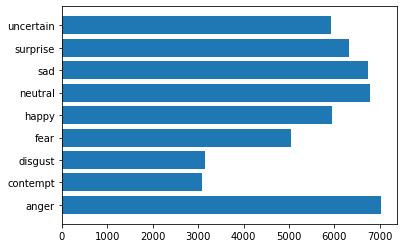

In [6]:
#Посмотрим на распределение признаков

plt.barh(train_df.groupby('emotion').count().index, train_df.groupby('emotion').count()['image_path'])
plt.show()

-----

Подготовим различные дополнительные функции

In [7]:
#Функция для отображения человека и эмоции
def human_emotion_show(images, labels, predicted_labels=None):
    names = {v:k for k, v in train_data.class_indices.items()} #Словарь с эмоциями (ключ:значение -> значение:ключ)
    
    fig = plt.figure(figsize=(12,12))
    for i in range(20):
        plt.subplot(5,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        plt.imshow(images[i])
        
        if predicted_labels is not None:
            title_obj = plt.title(
                f'Real: {names[np.argmax(labels[i])]} \n Pred: {names[np.argmax(predicted_labels[i])]}'
            )
            if np.argmax(labels[i]) != np.argmax(predicted_labels[i]):
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Emotion: {names[np.argmax(labels[i])]}")
    fig.tight_layout()





------

# Нейронная сеть

Напишем архитектуру нейронной сети VGGFace и загрузим необходимые веса. После чего дообучим на наших данных.




---



In [8]:
#Зададим размер batch и размер изображения
BATCH_SIZE = 64
IMG_SHAPE  = 224

Загрузим предварительно скаченные веса датасета VGG Face

In [ ]:
#веса модели можно скачать по ссылке
# https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing

Препроцессинг и аугментация.

In [9]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [10]:
#Создадим необходимые train (80%) и validation (20%) datasets
#Зададим некоторые параметры аугментации

data_image_gen = ImageDataGenerator(
                                    preprocessing_function=preprocess_input,
#                                     rescale=1./255,
                                    rotation_range=40, #Добавить поворот
                                    shear_range=0.2, #Добавить сдвиг
                                    zoom_range=0.2, #Добавить увеличение
                                    horizontal_flip=True, #Добавить зеркальный поворот
                                    fill_mode="nearest", #Заполняем пробелы
                                    validation_split=0.2)

train_data = data_image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                                directory=base_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                class_mode='categorical', 
                                                subset='training')

valid_data = data_image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                                directory=base_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                class_mode='categorical', 
                                                subset='validation')

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


In [11]:
#Изображения и лэйблы

train_images, train_labels = next(train_data)
val_images, val_labels = next(valid_data)

print(f' Размер train_data: {train_images.shape}','\n', f'Размер train_labels: {train_labels.shape}','\n')
print(f' Размер validation_data: {val_images.shape}','\n', f'Размер validation_labels: {val_labels.shape}')

 Размер train_data: (64, 224, 224, 3) 
 Размер train_labels: (64, 9) 

 Размер validation_data: (64, 224, 224, 3) 
 Размер validation_labels: (64, 9)


In [12]:
#Количество определенных эмоций (по сути, кол-во классов)
n_emotions = train_labels.shape[1]
n_emotions

9

Нейронная сеть

In [14]:
#Модель
model_VGGFace = tf.keras.Sequential([tf.keras.layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)), 
                                           tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'), 
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'),
                                           tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)), 

                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'), 
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'),
                                           tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),

                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'), 
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'),
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'),
                                           tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),

                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'), 
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'),
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'),
                                           tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),


                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'), 
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'),
                                           tf.keras.layers.ZeroPadding2D((1,1)), 
                                           tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'),
                                           tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)),

                                           tf.keras.layers.Convolution2D(4096, (7, 7), activation='relu'),
                                           tf.keras.layers.Dropout(0.5),
                                           tf.keras.layers.Convolution2D(4096, (1, 1), activation='relu'),
                                           tf.keras.layers.Dropout(0.5),
                                           tf.keras.layers.Convolution2D(2622, (1, 1)),

                                           tf.keras.layers.Flatten()])

#загрузим веса VGGFace
model_VGGFace.load_weights(dir_path + '/vgg_face_weights.h5')

#Посмотрим на структуру  модели
model_VGGFace.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_13 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)    

In [16]:
#Возьмём только основную часть модели до слоя 

model_base_VGGFace = tf.keras.Model([model_VGGFace.input],
                                    model_VGGFace.get_layer('flatten').output)

#Заморозим базовую модель (так веса модели сформированы датасетом VGGFace)
#Если веса imagenet, то все слои разморозить (=True)
model_base_VGGFace.trainable = True

#Количество слоёв
print("Количество слоев в базовой модели: ", len(model_base_VGGFace.layers))

Количество слоев в базовой модели:  38


In [17]:
#Допишем модель
emotion_model_base_VGGFace = tf.keras.Sequential([model_base_VGGFace,
                                                  tf.keras.layers.Dense(512, activation='relu'), 
                                                  tf.keras.layers.Dense(n_emotions, activation='softmax')])

In [18]:
#Параметры модели
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.categorical_accuracy

#Компиляция
emotion_model_base_VGGFace.compile(optimizer=optim, loss=loss, metrics=metric)

In [19]:
#Сохраним наилучший результат модели
model_best_path = Path(dir_path + '/model_best_VGGFace')
model_best_path.mkdir(exist_ok=True)

model_best_filename = 'checkpoint_best.h5'  
model_best_path_total = str(model_best_path/model_best_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_best_path_total, 
                                                monitor='val_accuracy', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='max')

**Обучение модели**

___

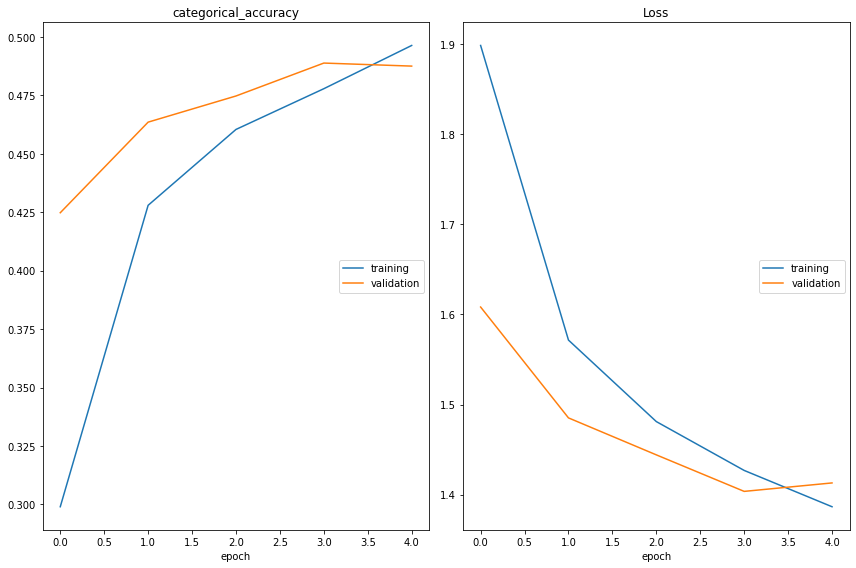

categorical_accuracy
	training         	 (min:    0.299, max:    0.496, cur:    0.496)
	validation       	 (min:    0.425, max:    0.489, cur:    0.488)
Loss
	training         	 (min:    1.387, max:    1.899, cur:    1.387)
	validation       	 (min:    1.404, max:    1.608, cur:    1.413)
626/626 [==============================] - 1185s 2s/step - loss: 1.3865 - categorical_accuracy: 0.4964 - val_loss: 1.4129 - val_categorical_accuracy: 0.4876


In [20]:
EPOCHS = 5

history = emotion_model_base_VGGFace.fit(train_data, 
                                         validation_data=valid_data, 
                                         epochs=EPOCHS, 
                                         callbacks=[checkpoint, PlotLossesCallback()])

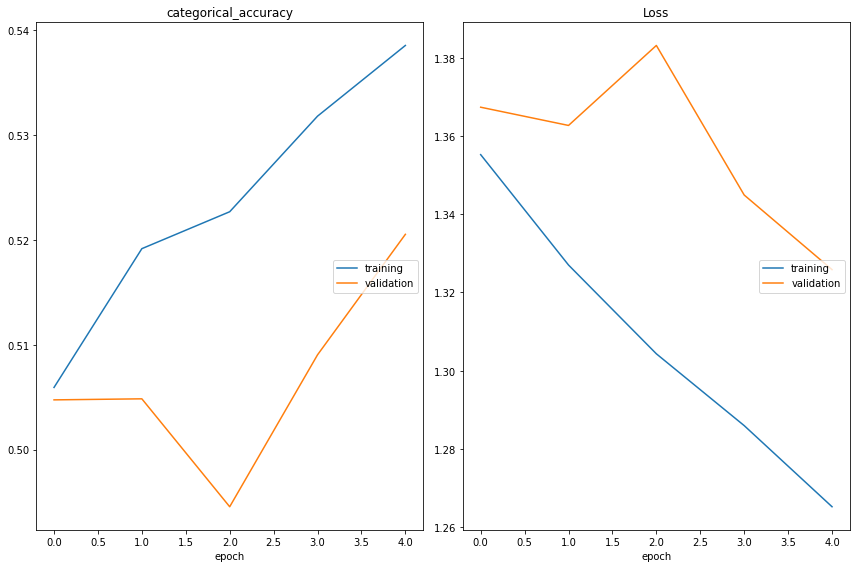

categorical_accuracy
	training         	 (min:    0.506, max:    0.539, cur:    0.539)
	validation       	 (min:    0.495, max:    0.521, cur:    0.521)
Loss
	training         	 (min:    1.265, max:    1.355, cur:    1.265)
	validation       	 (min:    1.326, max:    1.383, cur:    1.326)
626/626 [==============================] - 1185s 2s/step - loss: 1.2652 - categorical_accuracy: 0.5385 - val_loss: 1.3258 - val_categorical_accuracy: 0.5205


In [21]:
EPOCHS = 5

history = emotion_model_base_VGGFace.fit(train_data, 
                                         validation_data=valid_data, 
                                         epochs=EPOCHS, 
                                         callbacks=[checkpoint, PlotLossesCallback()])

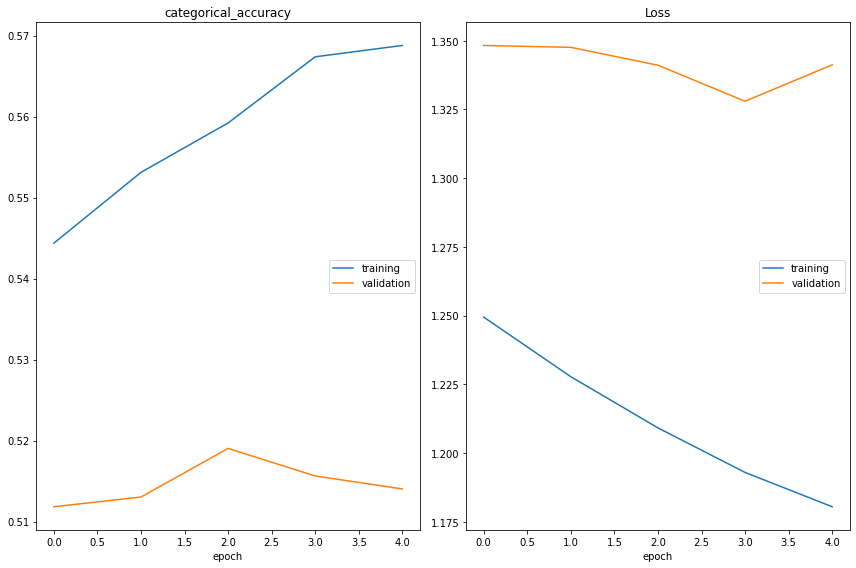

categorical_accuracy
	training         	 (min:    0.544, max:    0.569, cur:    0.569)
	validation       	 (min:    0.512, max:    0.519, cur:    0.514)
Loss
	training         	 (min:    1.180, max:    1.249, cur:    1.180)
	validation       	 (min:    1.328, max:    1.348, cur:    1.341)
626/626 [==============================] - 1156s 2s/step - loss: 1.1805 - categorical_accuracy: 0.5688 - val_loss: 1.3412 - val_categorical_accuracy: 0.5140


In [22]:
EPOCHS = 5

history = emotion_model_base_VGGFace.fit(train_data, 
                                         validation_data=valid_data, 
                                         epochs=EPOCHS, 
                                         callbacks=[checkpoint, PlotLossesCallback()])

In [23]:
#Сохраним модель
emotion_model_base_VGGFace.save(dir_path + '/checkpoint_best_2.h5')

# #Сохранить модель
# emotion_model_base_VGGFace.save(dir_path + '/model_best_VGGFace/best_model')

In [ ]:
# #Загрузим веса
# emotion_model_base_VGGFace.load_weights(dir_path + '/model_best_VGGFace/checkpoint_best.h5')

In [16]:
#Предсказание модели
val_predictions = emotion_model_base_VGGFace.predict(val_images)

#Визуализация
human_emotion_show(val_images, val_labels)

# Выводы

Обучено 15 эпох.

Одна эпоха обучается 20 минут. 

На валидационной выборке **точность 52.1%**, loss 1.33. 